In [5]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
pd.options.plotting.backend = "plotly"

import sys
sys.path.insert(0, 'driftpy/src/')
import driftpy
print(driftpy.__file__)

import numpy as np 
from sim.sim import DriftSim, load_hist_oracle

/Users/zanes/Documents/drift-sim/driftpy/src/driftpy/__init__.py


running simulation for 1569 timesteps
running sim from timestamp 0 to 1569
skipping time step: 0 ... ch time: 2
skipping time step: 1 ... ch time: 2
repegging 169981 -> 170026
repeg cost: 0.00370444414464
repegging 170026 -> 170138
repeg cost: 0.021071033692979198
repegging 170138 -> 170050
repeg cost: -0.040336371249152
repegging 170050 -> 170191
repeg cost: 0.0762324160978944
repegging 170191 -> 170213
repeg cost: 0.0120236214540288
repegging 170213 -> 170240
repeg cost: 0.015548990190336
repegging 170240 -> 170295
repeg cost: 0.03361133990016
repegging 170295 -> 170323
repeg cost: 0.017275565971865598
repegging 170323 -> 170338
repeg cost: 0.00934279143168
repegging 170338 -> 170347
repeg cost: 0.0056584845762048
repegging 170347 -> 170353
repeg cost: 0.0038075276691456003
repegging 170353 -> 170357
repeg cost: 0.0025618206982144
repegging 170357 -> 170360
repeg cost: 0.0019389667995648
repegging 170360 -> 170363
repeg cost: 0.001956567765504
repegging 170363 -> 170365
repeg cost: 0

  0%|                                                                                    | 0/1569 [01:05<?, ?it/s]


repegging 170665 -> 170529
repeg cost: -0.5287062556274688
repegging 170529 -> 170505
repeg cost: -0.093441772118016
repegging 170505 -> 170504
repeg cost: -0.0039285791676928
repegging 170504 -> 170240
repeg cost: -1.1238092072435713
repegging 170240 -> 170239
repeg cost: -0.0042803375548416
repegging 170239 -> 170470
repeg cost: 1.0687759979990015
repegging 170470 -> 170578
repeg cost: 0.500320705499136
repegging 170578 -> 170625
repeg cost: 0.218282950999296
repegging 170625 -> 170666
repeg cost: 0.1969017117629952
repegging 170666 -> 170686
repeg cost: 0.096166744881152
repegging 170686 -> 170696
repeg cost: 0.048141930271744
repegging 170696 -> 170702
repeg cost: 0.0289202908035072
repegging 170702 -> 170705
repeg cost: 0.0144777111046656
repegging 170705 -> 170706
repeg cost: 0.004831758832896
repegging 170706 -> 170707
repeg cost: 0.004837613929984
repegging 170707 -> 170708
repeg cost: 0.0048434689927168
repegging 170708 -> 170709
repeg cost: 0.004855179049728
repegging 170709 

 20%|██████████████▌                                                         | 318/1569 [00:00<00:00, 3173.75it/s]

{'base_asset_reserve': 3676216205255179776, 'quote_asset_reserve': 3676216205255179776, 'funding_period': 3600, 'sqrt_k': 3676216205255179776, 'peg_multiplier': 169981, 'last_funding_rate': 0, 'last_funding_rate_ts': 0, 'cumulative_funding_rate_long': 0, 'cumulative_funding_rate_short': 0, 'last_oracle_price': 169.981609, 'last_oracle_conf': 0, 'last_oracle_normalised_price': 169.981609, 'last_oracle_price_twap': 169.981609, 'last_oracle_price_twap_ts': 0, 'last_mark_price_twap': 169.981, 'last_bid_price_twap': 169.981, 'last_ask_price_twap': 169.981, 'last_mark_price_twap_ts': 0, 'net_base_asset_amount': 0, 'base_spread': 1000.0, 'mark_std': 0, 'buy_intensity': 0, 'sell_intensity': 0, 'last_spread': 1000.0, 'bid_price_before': 169.89602012381252, 'ask_price_before': 170.06600112381253, 'total_fee': 0, 'total_fee_minus_distributions': 0, 'strategies': 'PrePeg', 'minimum_quote_asset_trade_size': 10000000}
{'base_asset_reserve': 3676216205255179776, 'quote_asset_reserve': 367621620525517

 60%|███████████████████████████████████████████▍                            | 946/1569 [00:00<00:00, 2920.26it/s]

{'base_asset_reserve': 3.6761975891390915e+18, 'quote_asset_reserve': 3.6762348214655396e+18, 'funding_period': 3600, 'sqrt_k': 3676216205255179776, 'peg_multiplier': 170358, 'last_funding_rate': 0, 'last_funding_rate_ts': 0, 'cumulative_funding_rate_long': 0, 'cumulative_funding_rate_short': 0, 'last_oracle_price': 170.359817, 'last_oracle_conf': 0, 'last_oracle_normalised_price': 169.981609, 'last_oracle_price_twap': 170.00758479227895, 'last_oracle_price_twap_ts': 318, 'last_mark_price_twap': 170.0066891077619, 'last_bid_price_twap': 169.999366769356, 'last_ask_price_twap': 170.01376518497634, 'last_mark_price_twap_ts': 318, 'net_base_asset_amount': 18606811513856.0, 'base_spread': 1000.0, 'mark_std': 0.0017246036966582778, 'buy_intensity': 0, 'sell_intensity': 0, 'last_spread': 1000.0, 'bid_price_before': 170.27455072353965, 'ask_price_before': 170.44491044347572, 'total_fee': 475440.6294679007, 'total_fee_minus_distributions': 333475.11102955195, 'strategies': 'PrePeg', 'minimum_q

100%|███████████████████████████████████████████████████████████████████████| 1569/1569 [00:00<00:00, 2999.50it/s]

{'base_asset_reserve': 3.6761426254949233e+18, 'quote_asset_reserve': 3.6762897864881705e+18, 'funding_period': 3600, 'sqrt_k': 3676216205255179776, 'peg_multiplier': 170814, 'last_funding_rate': 0, 'last_funding_rate_ts': 0, 'cumulative_funding_rate_long': 0, 'cumulative_funding_rate_short': 0, 'last_oracle_price': 171.053422, 'last_oracle_conf': 0, 'last_oracle_normalised_price': 169.981609, 'last_oracle_price_twap': 170.18071818917724, 'last_oracle_price_twap_ts': 1256, 'last_mark_price_twap': 170.15765736299508, 'last_bid_price_twap': 170.13227941339807, 'last_ask_price_twap': 170.18252588085895, 'last_mark_price_twap_ts': 1256, 'net_base_asset_amount': 73542984166912.0, 'base_spread': 1000.0, 'mark_std': 0.0068277407926586875, 'buy_intensity': 0, 'sell_intensity': 0, 'last_spread': 1000.0, 'bid_price_before': 170.7354327365098, 'ask_price_before': 170.90625356898624, 'total_fee': 1882264.2444179996, 'total_fee_minus_distributions': 12726.218475672002, 'strategies': 'PrePeg', 'mini

finish res
Index(['m0_mark_price', 'm0_oracle_price', 'm0_bid_price', 'm0_ask_price',
       'm0_wouldbe_peg', 'm0_wouldbe_peg_cost', 'm0_predicted_long_funding',
       'm0_predicted_short_funding', 'm0_last_mid_price_twap',
       'm0_repeg_to_oracle_cost', 'm0_market_index',
       'm0_base_asset_amount_long', 'm0_base_asset_amount_short',
       'm0_base_asset_amount', 'm0_total_base_asset_amount',
       'm0_open_interest', 'm0_total_exchange_fees', 'm0_total_mm_fees',
       'm0_margin_ratio_initial', 'm0_margin_ratio_maintenance',
       'm0_margin_ratio_partial', 'm0_base_asset_reserve',
       'm0_quote_asset_reserve', 'm0_funding_period', 'm0_sqrt_k',
       'm0_peg_multiplier', 'm0_last_funding_rate', 'm0_last_funding_rate_ts',
       'm0_cumulative_funding_rate_long', 'm0_cumulative_funding_rate_short',
       'm0_last_oracle_price', 'm0_last_oracle_conf',
       'm0_last_oracle_normalised_price', 'm0_last_oracle_price_twap',
       'm0_last_oracle_price_twap_ts', 'm0_last_

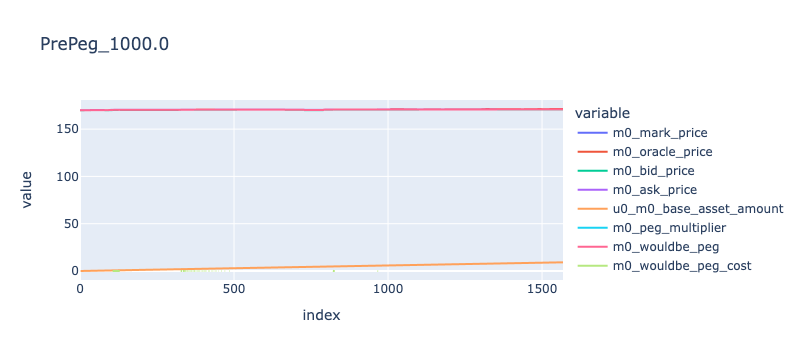

In [7]:
import os
import datetime
from sim.agents import * 
from programs.clearing_house.state import * 
from sim.events import OpenPositionEvent
from sim.helpers import random_walk_oracle, rand_heterosk_oracle, class_to_json
import pickle as cPickle

SIM_NAME = 'sim-results/sim-solhist'
# load_hist_oracle('LUNA-PERP', 'sim-solhist/oracle_prices.csv')

def make_ch(base_spread, strategies=''):
    oracle = Oracle(SIM_NAME+'/oracle_prices.csv')
    # oracle.to_csv(SIM_NAME+'/oracle_prices.csv')
    amm = AMM(
        oracle=oracle, 
        base_asset_reserve=int(367621.62052551797 * 1e13), 
        quote_asset_reserve=int(367621.62052551797 * 1e13),
        funding_period=60*60,
        peg_multiplier=int(oracle.prices[0]*1e3),
        base_spread = base_spread,
        strategies = strategies
    )
    market = Market(amm)
    
    if strategies=='':
        strategies = 'v1'
    ch_name = strategies+'_'+str(base_spread)
    
    fee_structure = FeeStructure(numerator=1, denominator=1000)
    clearing_house = ClearingHouse([market], fee_structure)
    clearing_house.name = ch_name

    return clearing_house


arb_agent1 = Noise(1, 0, 0, lookahead=0)
agents = [arb_agent1]

sim1 = DriftSim(SIM_NAME, clearing_house=make_ch(0), agents=agents)
sim2 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, ''), agents=agents)
sim2 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, 'PrePeg'), agents=agents)
sim3 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, 'InventorySkew'), agents=agents)
sim4 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, 'VolatilityScale'), agents=agents)
sim5 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, 'OracleRetreat'), agents=agents)
sim6 = DriftSim(SIM_NAME, clearing_house=make_ch(1e3, 'PrePeg'), agents=agents)


sims = [sim1, sim2, sim3, sim4, sim5, sim6]
sims = [sim6]

for sim_i in sims:
    res = sim_i.run()
    print('finish sim')
    res_df = sim_i.to_df(save=True)
    print('finish res')
    print(res_df.columns)
    toplt = res_df[[
        'm0_mark_price', 'm0_oracle_price', 'm0_bid_price', 'm0_ask_price',
        # 'bid_price_before', 'ask_price_before',
        'u0_m0_base_asset_amount',
        # 'user0.quote_asset_amount',
        # 'cumulative_funding_rate_long',
        'm0_peg_multiplier', 'm0_wouldbe_peg', 'm0_wouldbe_peg_cost'
        # 'base_asset_amount',
        # 'user0.base_asset_amount', 'user0.total_collateral', 'mark_std', 'last_spread',
        # 'total_fees', 
        # 'predicted_long_funding',
        # 'total_exchange_fees', 'total_mm_fees'
    ]].replace(0, np.nan)
    toplt['u0_m0_base_asset_amount']/=1e13
    # toplt['user0.quote_asset_amount']/=1e6
    toplt['m0_peg_multiplier']/=1e3

    # toplt['base_asset_amount']/=1e13
    fig = toplt.plot(title=sim_i.clearing_house.name)
    fig.show()

In [ ]:
# res_df[['base_asset_reserve', 'quote_asset_reserve', 'sqrt_k',]].plot()

In [ ]:
# ! echo 'hi'

In [ ]:
# ! cd protocol-v1/ && bash stress/run_local_sim.sh ../sim-results/sim-solhist/chPrepeg_1000.0

In [ ]:
# toplt['total_exchange_fees'].diff().plot()

# (res_df['user0.base_asset_amount']/1e13).plot()

# res_df['peg_multiplier'].plot()

In [ ]:
res_df[['user0.quote_asset_amount', 'user0.last_cumulative_funding_rate',
       'user0.last_funding_rate_ts', 'user0.market_index', 'user0.collateral',
       'user0.position0.upnl', 'user0.total_collateral',
       'user0.position0.ufunding', 'user0.free_collateral',
       'user0.margin_ratio', 'user0.total_position_value']].plot()

In [ ]:
res_df[['repeg_to_oracle_cost', 'total_fee', 'total_exchange_fees', 'total_mm_fees',
        'total_fee_minus_distributions']].plot()

In [ ]:
print(res_df.columns)
r = res_df[['last_oracle_price_twap',
       'last_mark_price_twap',
        'last_bid_price_twap',
            'last_ask_price_twap',
       'last_mid_price_twap',
       ]]
# r = res_df[['oracle_price',
#        'mark_price',
#         'bid_price',
#             'ask_price',
#        ]]
# r['mid_price'] = (r['bid_price']+r['ask_price'])/2
r.plot()

In [ ]:
res_df[['predicted_long_funding','predicted_short_funding']].plot()